In [1]:
# StochasticHeat - Program to calculate trajectories for the stochastic heat equation 
#                  See Intro_FHD_notes.pdf for documentation on the theory and numerics

# Set up configuration options and special features
import numpy as np                 # Use numerical python library
import matplotlib.pyplot as plt    # Use plotting python library
# Display plots in notebook window
%matplotlib inline                 

In [2]:
#* Set option flags and key parameters for the simulation
BC_FLAG = 1                   # Boundary condition flag (0: Periodic; 1: Dirichlet)
NONEQ_FLAG = 0                # Non-equilibrium flag (0: Thermodynamic equilibrium; 1: Temperature gradient)
if( BC_FLAG == 0 and NONEQ_FLAG == 1 ):
    print('ERROR: Periodic boundary conditions are only for thermodynamic equilibrium')
    NONEQ_FLAG = 0            # Reset the flag to equilibrium
PERTURB_FLAG = 1              # Start from perturbed initial condition (0: No; 1: Yes)
STOCH_FLAG = 1                # Thermal fluctuations? (0: No, deterministic; 1: Yes, stochastic)
SCHEME_FLAG = 0               # Numerical scheme (0: Forward Euler; 1: Predictor-corrector)

Ncells = 32                   # Number of cells (including boundary cells '0' and 'Ncells-1' )
MegaSteps = 2                 # Number of simulation timesteps in millions
# Recommend at least 2 million steps for equilibrium systems, 20 million for non-equilibrium systems

In [3]:
#* Set physical parameters for the system (iron bar)
kB = 1.38e-23       # Boltzmann constant (J/K)
mAtom = 9.27e-26    # Mass of iron atom (kg)
rho = 7870.         # Mass density of iron (kg/m^3)
c_V = 450.          # Specific heat capacity of iron (J/(kg K))
ThCond = 70.        # Thermal conductivity of iron (W/(m K))
Length = 1.0e-8     # System length (m)
Area = (5.0e-9)**2  # System cross-sectional area (m^2)

In [4]:
#* Set numerical parameters (time step, grid spacing, etc.).
if( BC_FLAG == 0 ):
    cellLo = 0;  cellHi = Ncells-1;     # For periodic BC, range of cells = { 0, 1, ..., Ncells-2 }
    faceLo = 0;  faceHi = Ncells-1;     # Face ii is left side of cell ii
else:
    cellLo = 1;  cellHi = Ncells-1;     # For Dirichlet BC, range of cells = { 1, 2, ..., Ncells-2 }
    faceLo = 1;  faceHi = Ncells-1;     # Face ii is left side of cell ii

dx = Length/(Ncells-1)     # Grid size (m)
dV = Area*dx               # Volume of grid cell (m^3)
xx = np.zeros(Ncells)
for ii in range(Ncells):
    xx[ii] = ii * dx       # Cell center positions (m)

kappa = ThCond / (rho * c_V )                # Coefficient in deterministic heat equation
# Coefficient in stochastic heat equation
if( STOCH_FLAG == 1 ):
    alpha = np.sqrt( 2 * kB * kappa / (rho * c_V) )   
else:
    alpha = 0.  # Set alpha = 0 to turn off thermal fluctuations

stabilityFactor = 0.1                         # Numerical stability if stabilityFactor < 1.
dt = stabilityFactor * dx**2 /( 2. * kappa )  # Timestep (s)

In [5]:
#* Set initial conditions for temperature
Tref = 300.      # Reference temperature (K)
if( NONEQ_FLAG == 0 ):
    T_Left = Tref; T_Right = Tref       
else:
    Tdiff = 400.   # Temperature difference across the system
    T_Left = Tref - Tdiff/2.; T_Right = Tref + Tdiff/2. 
    
# Standard deviation of temperature in a cell at the reference temperature
Tref_SD = np.sqrt(kB*Tref**2 / (rho * c_V * dV))

# Set initial temperature and its deterministic steady-state value
T = np.zeros(Ncells); T0 = np.zeros(Ncells)
for ii in range(cellLo,cellHi):
    T0[ii] = T_Left + (T_Right-T_Left) * ii/(Ncells-1)      # Linear profile
    T[ii] = T0[ii] 
    if( PERTURB_FLAG == 1 ):
        T[ii] += Tref_SD*np.random.randn()  # Add random perturbation
    
if( BC_FLAG == 0 ):
    T0[cellHi] = T0[0]       # Copy first cell into last cell for periodic BCs
    T[cellHi] = T[0]       
else:
    T0[0] = T_Left;   T[0] = T_Left      # Set values in first and last cells
    T0[-1] = T_Right; T[-1] = T_Right    

System is iron bar with about  21224  atoms
System length =  10.0  (nm); volume =  250.00000000000003  (nm**3)
Number of timesteps =  2  million
Time step =  0.26323026609186856  (fs)
Number of cells =  32
++ DIRICHLET boundary conditions ++
Equilibrium temperature =  300.0  Kelvin
At T =  300.0 K, standard deviation sqrt(< dT^2 >) =  6.594441461995079 K
-- Forward Euler Scheme --


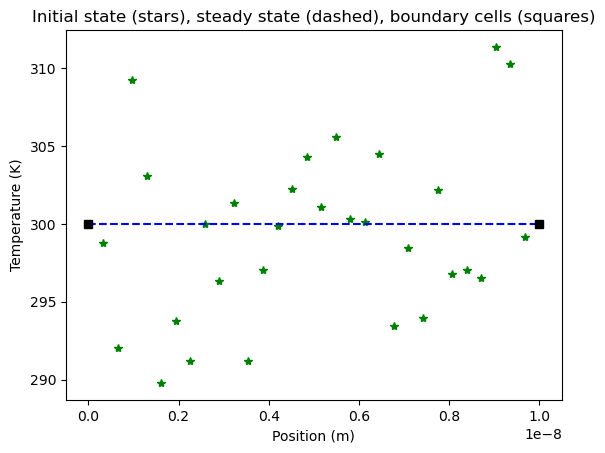

In [6]:
#* Summarize system parameters and initial state
print( 'System is iron bar with about ', int(rho*Length*Area/mAtom), ' atoms' )
print( 'System length = ',Length*1.0e9,' (nm); volume = ',
      (Length*Area)*1.0e27,' (nm**3)' )
print( 'Number of timesteps = ', MegaSteps,' million' )
print( 'Time step = ', dt*1.e15, ' (fs)' )
print( 'Number of cells = ', Ncells )
if( BC_FLAG == 0 ):
    print('** PERIODIC boundary conditions **')
else:
    print('++ DIRICHLET boundary conditions ++')

if( NONEQ_FLAG == 0 ):
    print('Equilibrium temperature = ',Tref,' Kelvin')
else:
    print('Fixed temperatures (K) = ',T_Left,' left; ',T_Right,' right')
print( 'At T = ',Tref,'K, standard deviation sqrt(< dT^2 >) = ', Tref_SD,'K' )
if( SCHEME_FLAG == 0 ):
    print('-- Forward Euler Scheme --')
else:
    print('== Predictor-Corrector Scheme ==')

# Plot temperature versus position
plt.plot(xx, T,'g*',xx, T0,'b--',xx[0],T[0],'sk',xx[-1],T[-1],'sk')
plt.xlabel('Position (m)'); plt.ylabel('Temperature (K)')
plt.title('Initial state (stars), steady state (dashed), boundary cells (squares)')
plt.show()

In [7]:
#* Initialize sampling plus misc. coefficients and arrays
Nsamp = 0                   # Count number of statistical samples
sumT  = np.zeros(Ncells)    # Running sum of T_i ; used to compute mean
sumT2 = np.zeros(Ncells)    # Running sum of (T_i)**2 ; used to compute variance
sumTT = np.zeros(Ncells)    # Running sum for correlation T_i * T_iCorr
sumSk = np.zeros(Ncells)    # Running sum for structure factor S(k)

iCorr = np.int_(Ncells/4)   # Grid point used for correlation

# Coefficients used in the main loop calculations
coeffDetFE = kappa * dt / dx**2
coeffStoFE = alpha * dt / dx
coeffZnoise = 1. / np.sqrt( dt * dV )

# Arrays used in the main loop calculations
Determ = np.zeros(Ncells); Stoch = np.zeros(Ncells)
Znoise = np.zeros(Ncells); Tface = np.zeros(Ncells)
PreT = np.copy(T)             # Used by Predictor-Corrector scheme
Spectrum = np.zeros(Ncells)   # Used to compute structure factor S(k)

In [8]:
#* Loop over the desired number of time steps.
NstepInner = 10                                       # Number of time steps (inner loop)
NstepOuter = np.int_(MegaSteps*1000000/NstepInner)    # Number of time steps (outer loop)
NskipOuter = NstepOuter/10        # Number of outer steps to skip before sampling begins
NdiagOuter = NstepOuter/20        # Number of outer steps between diagnostic outputs

for iOuter in range(NstepOuter):     # Outer loop

    # Print diagnostics
    if (iOuter % NdiagOuter) == 0 : 
        print( 'Finished ',np.int_(100*iOuter/NstepOuter),' percent of the time steps')
      
    for iInner in range(NstepInner):       # Inner loop

        # Deterministic update for temperature
        for ii in range(cellLo,cellHi):
            Determ[ii] = coeffDetFE * ( T[ ii+1 ] + T[ ii-1 ] - 2*T[ ii ] )
        if( BC_FLAG == 0 ):
            Determ[0] = coeffDetFE * ( T[ 1 ] + T[ cellHi-1 ] - 2*T[ 0 ] )  # Periodic BC
            
        # Generate random noise Z
        Znoise = coeffZnoise * np.random.normal(size=Ncells)
        if( BC_FLAG == 0 ):
            Znoise[-1] = Znoise[0]   # Periodic BC
        
        # Tface[ i ] is average between T of cells i-1 and i; value on the left face of cell i
        for ii in range(cellLo,cellHi):
            Tface[ii] = 0.5 * (T[ ii-1 ] + T[ ii ])     
        if( BC_FLAG == 0 ):
            Tface[cellHi] = Tface[0]   # Periodic BC
        else:
            Tface[cellHi] = 0.5 * (T[ cellHi-1 ] + T[ cellHi ])   # Dirichlet BC

        # Stochastic update for temperature
        for ii in range(cellLo,cellHi):
            Stoch[ii] = coeffStoFE * ( Tface[ii+1]*Znoise[ii+1] - Tface[ii]*Znoise[ii] )

        if( SCHEME_FLAG == 0 ):
            # Forward Euler scheme
            for ii in range(cellLo,cellHi):
                T[ii] += Determ[ii] + Stoch[ii]   # Total update for temperature
        else:
            # Predictor-Corrector scheme
            for ii in range(cellLo,cellHi):
                PreT[ii] = T[ii] + Determ[ii] + Stoch[ii]     # Predictor step
            if( BC_FLAG == 0 ):
                PreT[cellHi] = PreT[0]     # Periodic BC
            # Corrector step
            for ii in range(cellLo,cellHi):
                Determ[ii] = coeffDetFE * ( PreT[ ii+1 ] + PreT[ ii-1 ] - 2*PreT[ ii ] )
            if( BC_FLAG == 0 ):
                Determ[0] = coeffDetFE * ( PreT[ 1 ] + PreT[ cellHi-1 ] - 2*PreT[ 0 ] )  # Periodic BC     
            for ii in range(cellLo,cellHi):
                Tface[ii] = 0.5 * (PreT[ ii-1 ] + PreT[ ii ])    
            if( BC_FLAG == 0 ):
                Tface[cellHi] = Tface[0]   # Periodic BC
            else:
                Tface[cellHi] = 0.5 * (PreT[ cellHi-1 ] + PreT[ cellHi ])
            for ii in range(cellLo,cellHi):
                Stoch[ii] = coeffStoFE * ( Tface[ii+1]*Znoise[ii+1] - Tface[ii]*Znoise[ii] )
            for ii in range(cellLo,cellHi):
                T[ii] = 0.5*( T[ii] + PreT[ii] + Determ[ii] + Stoch[ii] )              

        if( BC_FLAG == 0 ):
            T[cellHi] = T[0]     # Periodic BC

    # End of Inner loop

  # Take statistical sample
    if( iOuter > NskipOuter ):
        Nsamp += 1
        for ii in range(cellLo,cellHi):
            sumT[ii] += T[ii]            # Running sum for temperature average
            sumT2[ii] += T[ii]**2        # Running sum for temperature variance
            sumTT[ii] += T[ii]*T[iCorr]  # Running sum for temperature correlation
            
        if( NONEQ_FLAG == 0 ):
            # Take Fourier transform and record sampled spectrum in running sum
            Spectrum[cellLo:cellHi] = np.abs( np.fft.fft( T[cellLo:cellHi] ) )**2
            for ii in range(cellLo,cellHi):
                sumSk[ii] += Spectrum[ii]

# End of Outer loop

Finished  0  percent of the time steps
Finished  5  percent of the time steps
Finished  10  percent of the time steps
Finished  15  percent of the time steps
Finished  20  percent of the time steps
Finished  25  percent of the time steps
Finished  30  percent of the time steps
Finished  35  percent of the time steps
Finished  40  percent of the time steps
Finished  45  percent of the time steps
Finished  50  percent of the time steps
Finished  55  percent of the time steps
Finished  60  percent of the time steps
Finished  65  percent of the time steps
Finished  70  percent of the time steps
Finished  75  percent of the time steps
Finished  80  percent of the time steps
Finished  85  percent of the time steps
Finished  90  percent of the time steps
Finished  95  percent of the time steps


In [9]:
#* Calculate average, variance, and correlation
aveT = np.zeros(Ncells)     # Average < T_i >
varT = np.zeros(Ncells)     # Variance < (T_i - <T_i>)**2 >
corrT = np.zeros(Ncells)    # Correlation < T_i T_iCorr >

for ii in range(cellLo,cellHi):
    aveT[ii] = sumT[ii] / Nsamp
    varT[ii] = sumT2[ii]/Nsamp - aveT[ii]**2
for ii in range(cellLo,cellHi):
    corrT[ii] = sumTT[ii]/Nsamp - aveT[ii]*aveT[iCorr]

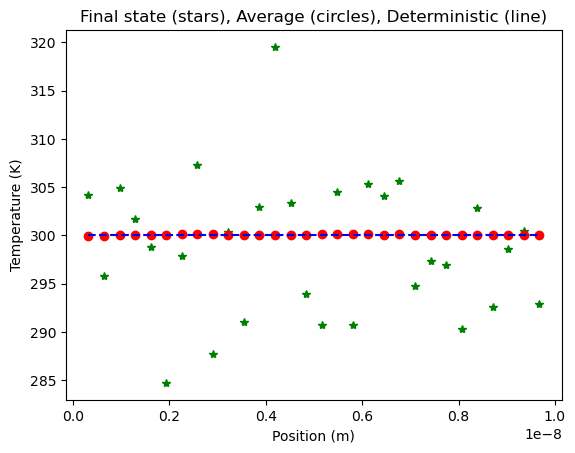

In [10]:
#* Plot temperature versus x
plt.plot(xx[cellLo:cellHi], T[cellLo:cellHi],'g*',
         xx[cellLo:cellHi],aveT[cellLo:cellHi],'ro',xx[cellLo:cellHi],T0[cellLo:cellHi],'b--')
plt.xlabel('Position (m)'); plt.ylabel('Temperature (K)')
plt.title('Final state (stars), Average (circles), Deterministic (line)')
plt.show()

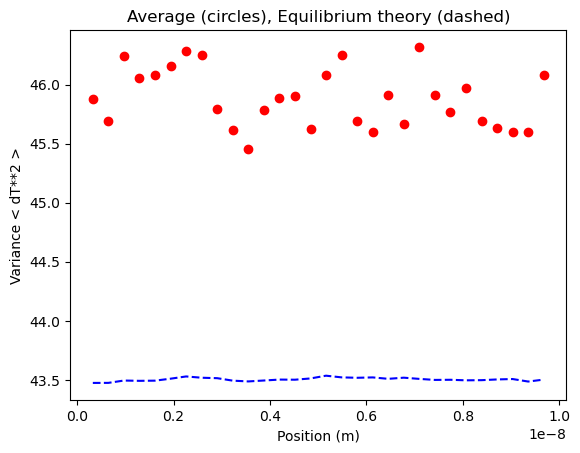

In [11]:
#* Plot varicance of temperature versus x; compare with theory
varT_Th = np.zeros(Ncells)   # Theoretical value
varT_Th[cellLo:cellHi] = kB*aveT[cellLo:cellHi]**2 / (rho * c_V * dV)  
# Conservation of energy correction for periodic boundary case
if( BC_FLAG == 0 ):
    varT_Th *= (1 - 1/(Ncells-1)) 
    
plt.plot(xx[cellLo:cellHi], varT[cellLo:cellHi],'ro',
         xx[cellLo:cellHi],varT_Th[cellLo:cellHi],'b--')
plt.xlabel('Position (m)'); plt.ylabel('Variance < dT**2 >')
plt.title('Average (circles), Equilibrium theory (dashed)')
plt.show()

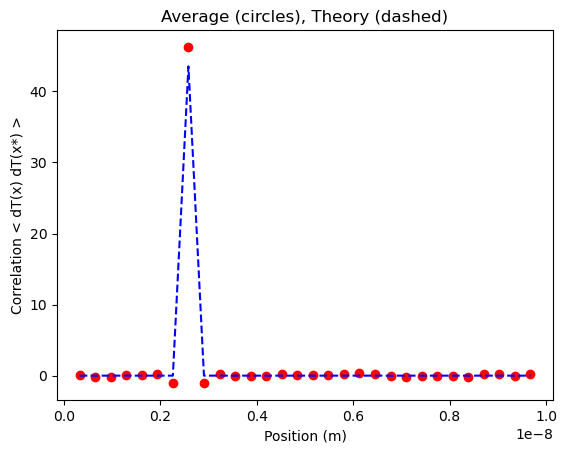

Correlation for x* =  2.5806451612903225e-09  (m)


In [12]:
#* Plot temperature cell correlation versus x
varTheory = kB*aveT[iCorr]**2 / (rho * c_V * dV)  # Temperature variance in cell iCorr
if( BC_FLAG == 0 ):
    corrT_Th = - varTheory * 1/(Ncells-1) * np.ones(Ncells)  # Conservation of energy correction
    corrT_Th[iCorr] = varTheory * (1 - 1/(Ncells-1))         # for periodic boundary case
else:
    corrT_Th = np.zeros(Ncells)                              # Kronecker delta correlation
    corrT_Th[iCorr] = varTheory                              # for Dirichlet boundary case
    
plt.plot(xx[cellLo:cellHi], corrT[cellLo:cellHi],'ro',
         xx[cellLo:cellHi],corrT_Th[cellLo:cellHi],'b--')
plt.xlabel('Position (m)'); plt.ylabel('Correlation < dT(x) dT(x*) >')
plt.title('Average (circles), Theory (dashed)')
plt.show()
print('Correlation for x* = ', xx[iCorr],' (m)')

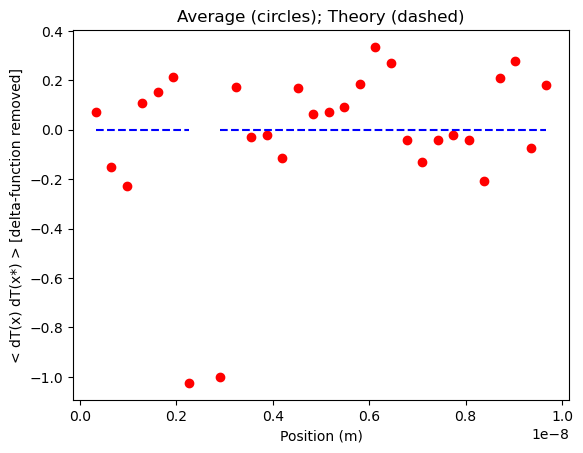

In [13]:
#* Plot temperature cell correlation versus x WITHOUT the equilibrium delta function
corrTd = np.array(corrT)
corrTd[iCorr] = np.nan        # Delete data point at iCorr using NaN

# Calculate theoretical values for < dT(x) dT(x') > where x' = xx[iCorr]
if( NONEQ_FLAG == 0 ):
    corrTd_Th = np.array(corrT_Th)
    corrTd_Th[iCorr] = np.nan        # Delete data point at iCorr using NaN
else:                                      
    corrTd_Th = np.zeros(Ncells)
    for ii in range(Ncells):
        # Non-equilibrium correlation; see J. Stat. Phys. 47 209 (1987)
        corrTd_Th[ii] = kB*(T_Right-T_Left)**2 / (rho * c_V * Area * Length**3)
        if( ii < iCorr ):
            corrTd_Th[ii] *= xx[ii]*(Length - xx[iCorr])
        else:
            corrTd_Th[ii] *= xx[iCorr]*(Length - xx[ii])                                 

plt.plot(xx[cellLo:cellHi], corrTd[cellLo:cellHi],'ro',
         xx[cellLo:cellHi],corrTd_Th[cellLo:cellHi],'b--')
plt.xlabel('Position (m)'); plt.ylabel('< dT(x) dT(x*) > [delta-function removed]')
plt.title('Average (circles); Theory (dashed)')
plt.show()

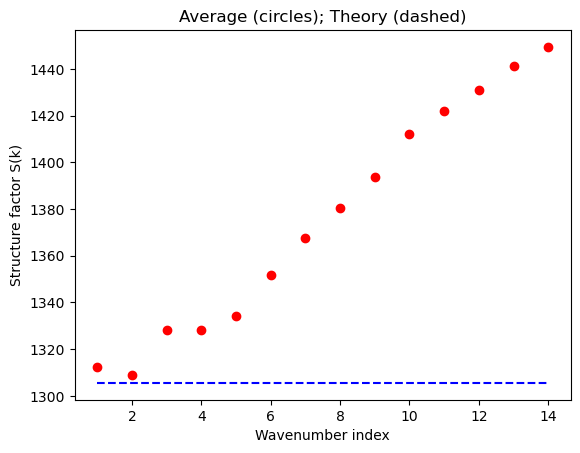

In [14]:
#* Compute the measured structure factor and compare with linear theory
if( NONEQ_FLAG == 0 ):     # Only compute S(k) for equilibrium 
    NN = len(range(cellLo,cellHi))
    Sk = np.zeros(NN)                           # Power spectrum S(k), AKA the structure factor
    Sk[0:NN] = sumSk[cellLo:cellHi] / Nsamp     # Average S(k)
    Nyq = np.int_(np.floor(NN/2))               # Nyquist frequency is kSpect[NNNy+1]
    ki = np.arange(1,Nyq)                       # Wavenumber index, skipping the zero index
    Sk_eq = varTheory*NN * np.ones(Nyq+1)       # Equilibrium structure factor, which is constant
    
    # Plot structure factor, skipping the k=0 wavenumber index
    plt.plot( ki, Sk[1:Nyq],'ro', ki, Sk_eq[1:Nyq],'b--',)
    plt.xlabel('Wavenumber index'); plt.ylabel('Structure factor S(k)')
    plt.title('Average (circles); Theory (dashed)')
    plt.show()